In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from source import data_import
from source.calculate_mean_psd import calculate_mean_psd
from source.constants import CHANNELS, FREQUENCY_RANGES

print(f"loaded channel names: {CHANNELS}")

loaded channel names: ['F4-C4', 'F3-C3', 'FT9-FT10', 'FZ-CZ', 'F7-T7', 'FP2-F4', 'T8-P8-1', 'T8-P8-0', 'FP1-F3', 'CZ-PZ']


In [127]:
# load data
df_pp = data_import.load_pyarrow(file_name="preprocessed_seg_all_60")
df_pp.shape

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/preprocessed_seg_all_60.arrow was loaded.


(6620160, 18)

In [128]:
test= df_pp.drop(['file','target'],axis=1)
missing_data = np.isnan(test)
missing_count = missing_data.sum()

# Display the count of missing values
print(missing_count)

channel
F4-C4             0
F3-C3             0
FT9-FT10          0
FZ-CZ             0
F7-T7             0
FP2-F4            0
T8-P8-1           0
T8-P8-0           0
FP1-F3            0
CZ-PZ             0
before_seizure    0
is_seizure        0
epoch             0
segment_id        0
seizure_start     0
seizure_id        0
dtype: int64


In [145]:
# df_pp = df_pp.iloc[:2_000_000,:]
# df_pp.shape

## Feature Extraction

In [162]:
# ignore for aggregation
ignore_col = []

# target definition
PRED_INTERVAL = 60
target_colname = 'target'

In [130]:
### aggregate Functions for mean psd:
delta = lambda x: calculate_mean_psd(x, frequency_ranges={'Delta' : FREQUENCY_RANGES['Delta']})[x.name]['Delta']
theta = lambda x: calculate_mean_psd(x, frequency_ranges={'Theta' : FREQUENCY_RANGES['Theta']})[x.name]['Theta']
gamma = lambda x: calculate_mean_psd(x, frequency_ranges={'Gamma': FREQUENCY_RANGES['Gamma']})[x.name]['Gamma']

delta_agg = pd.NamedAgg(column='delta', aggfunc=delta)
theta_agg = pd.NamedAgg(column='theta', aggfunc=theta)
gamma_agg = pd.NamedAgg(column='gamma', aggfunc=gamma)

### aggregate Functions for target:
target_foo = lambda x, pred_interval=PRED_INTERVAL: 0 < x.dt.total_seconds().min() < pred_interval


In [131]:
abs_mean = lambda x: x.apply(abs).mean()
abs_mean_agg = pd.NamedAgg(column='abs_mean', aggfunc=abs_mean)

In [213]:
df_features = df_pp.groupby(['epoch', 'segment_id']).agg(
    {C:['std',
        'var',
        #'mean',
        abs_mean_agg,
        delta_agg,
        theta_agg,
        gamma_agg
        ] for C in CHANNELS} | 
    {target_colname: [target_foo]} 
    ) 
df_features.head()

channel               F4-C4                                               \
                        std         var   abs_mean      delta      theta   
epoch segment_id                                                           
0     0           28.535956  814.300765  23.474976  91.216311  22.066200   
      1           15.763829  248.498307  12.224155  38.354721   5.081434   
      2           15.423302  237.878237  12.624893  37.979591  17.939820   
      3           19.534544  381.598402  14.705306  17.657032  14.363613   
      4           11.926589  142.243524   9.669304  11.649572   5.357976   

channel                         F3-C3                                    ...  \
                     gamma        std         var   abs_mean      delta  ...   
epoch segment_id                                                         ...   
0     0           1.361588  26.318663  692.672010  22.161551  84.172459  ...   
      1           2.206003  17.842494  318.354586  14.392837  52.233751  ...   
      2           1.250689  17.309557  299.620748  13.648520  71.069314  ...   
      3           0.886137  23.789589  565.944568  19.939037  93.422189  ...   
      4           0.655076  14.409950  207.646670  11.128378  24.074110  ...   

channel                FP1-F3                             CZ-PZ              \
                        delta       theta      gamma        std         var   
epoch segment_id                                                              
0     0           3299.014312  133.693556  24.922660  15.911194  253.166088   
      1             91.956241   18.439422  26.285195  19.455036  378.498434   
      2             18.244851   12.898840  19.709367  10.904365  118.905170   
      3              8.603413   11.214552  28.504306  16.657623  277.476413   
      4             44.014189   14.762290  15.644881  11.409362  130.173550   

channel                                                       target  
                   abs_mean      delta      theta     gamma <lambda>  
epoch segment_id                                                      
0     0           12.757492  16.902136   9.094517  0.397391    False  
      1           15.971641  77.795698  11.034774  0.323830    False  
      2           14.165546  12.596440  10.404335  0.182872    False  
      3           13.488792  17.872971  20.929250  0.237983    False  
      4            8.883672  15.173503   8.389444  0.373024    False  

[5 rows x 61 columns]

## Flatten Dataframe

In [214]:
# joining column names with agg functions, but leaving target column
df_features.columns = ['_'.join(col).strip() for col in df_features.columns.values if target_colname != col[0]] + [target_colname]
df_features.reset_index(inplace=True)
df_features.tail(10)


,epoch,segment_id,F4-C4_std,F4-C4_var,F4-C4_abs_mean,F4-C4_delta,F4-C4_theta,F4-C4_gamma,F3-C3_std,F3-C3_var,...,FP1-F3_delta,FP1-F3_theta,FP1-F3_gamma,CZ-PZ_std,CZ-PZ_var,CZ-PZ_abs_mean,CZ-PZ_delta,CZ-PZ_theta,CZ-PZ_gamma,target
25850,430,50,49.426071,2442.936515,41.038129,354.745654,26.726115,0.103330,52.659968,2773.072178,...,1472.675769,165.543483,0.196624,87.654792,7683.362622,67.680404,2366.065688,169.572076,0.082873,False
25851,430,51,55.503907,3080.683748,47.433894,725.909082,59.506356,0.084784,35.181746,1237.755256,...,1520.175067,180.597302,0.208722,70.857330,5020.761154,62.053315,716.101413,282.818599,0.081990,False
25852,430,52,62.204786,3869.435416,52.265716,1059.099059,160.637536,0.137019,49.545852,2454.791460,...,1178.475304,241.762279,0.105725,82.447462,6797.584026,68.099829,733.079397,110.030786,0.202845,False
25853,430,53,42.618013,1816.295023,41.814122,141.020374,23.248539,0.140314,57.418013,3296.828211,...,155.776402,103.788137,0.219907,82.797009,6855.344652,70.549495,687.720017,186.980200,0.098512,False
25854,430,54,39.495856,1559.922631,32.199412,137.840981,61.726881,0.135566,38.618930,1491.421782,...,380.973632,97.773307,0.080616,107.070449,11464.081080,77.342170,5628.331110,421.212656,0.103651,False
25855,430,55,42.199732,1780.817352,35.104197,199.294654,29.125047,0.095960,53.164338,2826.446864,...,1171.198622,170.430666,0.325827,44.151061,1949.316171,36.395633,263.724765,72.544538,0.074845,False
25856,430,56,79.495663,6319.560372,69.680987,766.586022,38.186860,0.070636,63.795168,4069.823446,...,122.369026,170.211651,0.255789,84.320194,7109.895199,64.453101,838.483947,128.984153,0.129915,False
25857,430,57,99.757496,9951.557973,88.135144,2072.322148,235.761249,0.087496,80.661890,6506.340433,...,919.843265,70.438011,0.126130,80.077598,6412.421702,69.887542,617.550083,222.669281,0.089078,False
25858,430,58,51.606989,2663.281313,44.737615,474.889864,188.909825,0.084074,41.174085,1695.305283,...,1239.941786,88.921867,0.112852,73.390298,5386.135892,61.355920,1415.989575,84.728257,0.114984,False
25859,430,59,33.692272,1135.169163,29.144569,84.911408,79.231900,0.156342,49.851065,2485.128682,...,747.523643,375.554879,0.174379,51.746096,2677.658430,39.460570,404.365479,84.037479,0.046453,False


In [215]:
df_features.shape

(25860, 63)

In [216]:
#Preparing data to be scaled

num_features= df_features.drop(['epoch','segment_id','target'],axis =1)

from sklearn.preprocessing import StandardScaler, minmax_scale, MinMaxScaler

scaler = StandardScaler()
num_features_scaled = scaler.fit_transform(num_features)

/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:767

In [217]:
original_array =np.array(df_features)
target=original_array[:,-1]
target = target[:, np.newaxis]
segseiz_column = original_array[:, 0:2] ## epoch and segment_id
array_all_scaled = np.concatenate((segseiz_column, num_features_scaled, target), axis=1)
array_all_scaled.shape

(25860, 63)

In [10]:
# # Determine the number of epochs
# num_epochs = df_features.epoch.nunique()
# # # Determine the number of segments for each epoch
# num_segments = df_features.segment_id.nunique()  # Assuming there are 30 segments for each epocha
# num_features = array_all_scaled.shape[1]

# reshaped_all= array_all_scaled.reshape(num_epochs, num_segments, num_features)
# reshaped_all.shape

(77, 30, 73)

In [110]:
#array_all_scaled=original_array

In [218]:
import numpy as np


original_array =np.array(df_features)

# Extract the epoch column
epoch_column = original_array[:, 0]

# Determine the number of epochs (assuming epochs are from 1 to number of segments)
num_epochs = df_features.epoch.unique()[-1]

# Determine the number of segments for each epoch
num_segments = len(df_features.segment_id.unique())  # Assuming there are 30 segments for each epoch

# Initialize an empty 3D array
reshaped_array = np.empty((num_epochs,num_segments, array_all_scaled.shape[1]))

# Reshape the data for each epoch and insert it into the 3D array
for epoch in range(num_epochs):
    start_idx = epoch * num_segments
    end_idx = (epoch + 1) * num_segments
    reshaped_array[epoch,:, :] = array_all_scaled[start_idx:end_idx,:]

In [219]:
reshaped_array.shape

(430, 60, 63)

In [220]:
import numpy as np

# Assuming original_data_array has dimensions (batch, sequence, features)

num_batches, num_sequences, num_features = reshaped_array.shape

# Define the window size
window_size = 30

# Calculate the number of augmented batches
num_augmented_batches = num_sequences - window_size + 1

# Create an empty array for the augmented data
augmented_data_array = np.zeros((num_batches * num_augmented_batches, window_size, num_features))

# Iterate through batches
for batch_idx in range(num_batches):
    # Iterate through sequences to create augmented batches
    for seq_idx in range(num_augmented_batches):
        # Copy the window of data
        augmented_data_array[batch_idx * num_augmented_batches + seq_idx, :, :] = reshaped_array[batch_idx, seq_idx:seq_idx + window_size, :]

# The resulting augmented_data_array will have the desired structure



In [226]:
augmented_data_array.shape

(13330, 30, 63)

In [209]:
data=augmented_data_array
data = data[400,:,2:-1]

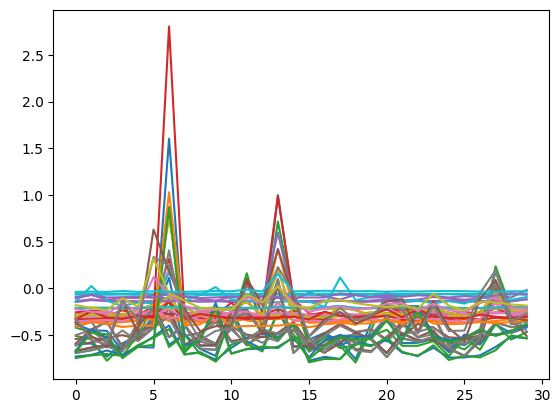

In [210]:
plt.plot(data)

In [225]:

np.save('data/feature_extract_reshaped.npy', augmented_data_array)

In [26]:
# from source.data_import import save_pyarrow

# save_pyarrow(df_features, file_name="feature_extracted")

/Users/anabroggini/Documents/bootcamp/ai2/source/../data/feature_extracted.arrow was successfully written.
